In [1]:
from utils import *

In [2]:
path_simus = Path('./simus_with_more_shifts/')
path_index = path_simus / 'index.parquet'

In [3]:
index = pl.scan_parquet(path_index).collect()
len(index)

354

In [4]:
percentiles = [0.99, 0.90, 0.75, 0.50, 0.25, 0.10, 0.01]

# Check runs' counts

In [5]:
paths = [str(path) for path in path_simus.glob('[0-9]*.parquet')]
paths = pl.DataFrame(paths, schema=['path'])
not_run = index.join(paths, on='path', how='anti')
print(len(index), len(paths), len(index.join(paths, on='path', how='inner')), len(not_run))

354 354 354 0


In [6]:
# not_run.equals(index.filter(pl.col('formation_length') <= 21))

# Check lengths of runs

In [7]:
lengths = [
    (path, pl.scan_parquet(path).select(pl.len()).collect().item())
    for path in paths.to_series()
]
lengths = pl.DataFrame(lengths, schema=['path', 'len'])
lenghts = lengths.join(index, on='path', how='left')
lenghts.describe()

shape: (9, 7)
┌────────────┬────────────────┬──────────────┬───────────────┬───────────┬────────────┬────────────┐
│ statistic  ┆ path           ┆ len          ┆ formation_len ┆ t_max     ┆ n_stocks   ┆ start_date │
│ ---        ┆ ---            ┆ ---          ┆ gth           ┆ ---       ┆ ---        ┆ ---        │
│ str        ┆ str            ┆ f64          ┆ ---           ┆ f64       ┆ f64        ┆ str        │
│            ┆                ┆              ┆ f64           ┆           ┆            ┆            │
╞════════════╪════════════════╪══════════════╪═══════════════╪═══════════╪════════════╪════════════╡
│ count      ┆ 354            ┆ 354.0        ┆ 354.0         ┆ 354.0     ┆ 354.0      ┆ 354        │
│ null_count ┆ 0              ┆ 0.0          ┆ 0.0           ┆ 0.0       ┆ 0.0        ┆ 0          │
│ mean       ┆ null           ┆ 88581.370056 ┆ 93.432203     ┆ 37.279661 ┆ 370.0      ┆ 2000-04-09 │
│ std        ┆ null           ┆ 38787.537221 ┆ 36.176498     ┆ 36.655711 ┆ 447.622615 ┆ null       │
│ min        ┆ simus_with_mor ┆ 35280.0      ┆ 42.0          ┆ 5.0       ┆ 10.0       ┆ 2000-01-03 │
│            ┆ e_shifts/0.par ┆              ┆               ┆           ┆            ┆            │
│            ┆ quet           ┆              ┆               ┆           ┆            ┆            │
│ 25%        ┆ null           ┆ 56525.0      ┆ 63.0          ┆ 10.0      ┆ 10.0       ┆ 2000-02-02 │
│ 50%        ┆ null           ┆ 80183.0      ┆ 126.0         ┆ 21.0      ┆ 100.0      ┆ 2000-04-03 │
│ 75%        ┆ null           ┆ 118760.0     ┆ 126.0         ┆ 63.0      ┆ 1000.0     ┆ 2000-06-02 │
│ max        ┆ simus_with_mor ┆ 195443.0     ┆ 126.0         ┆ 126.0     ┆ 1000.0     ┆ 2001-01-02 │
│            ┆ e_shifts/99.pa ┆              ┆               ┆           ┆            ┆            │
│            ┆ rque…          ┆              ┆               ┆           ┆            ┆            │
└────────────┴────────────────┴──────────────┴───────────────┴───────────┴────────────┴────────────┘

# Check n_postions for one run

In [8]:
path_run = paths.row(-40)[0]
path_run

'simus_with_more_shifts/228.parquet'

In [9]:
params, weights, universe = read_data_one_run(path_run, path_index)
weights = weights.collect()
universe = universe.collect()
params

{'formation_length': 126,
 't_max': 14,
 'n_stocks': 1000,
 'start_date': datetime.date(2000, 3, 3),
 'path': 'simus_with_more_shifts/228.parquet'}

In [10]:
# all the positions are taken on the universe
assert weights.join(universe, on=keys, how='anti').is_empty()

<Figure size 900x500 with 0 Axes>

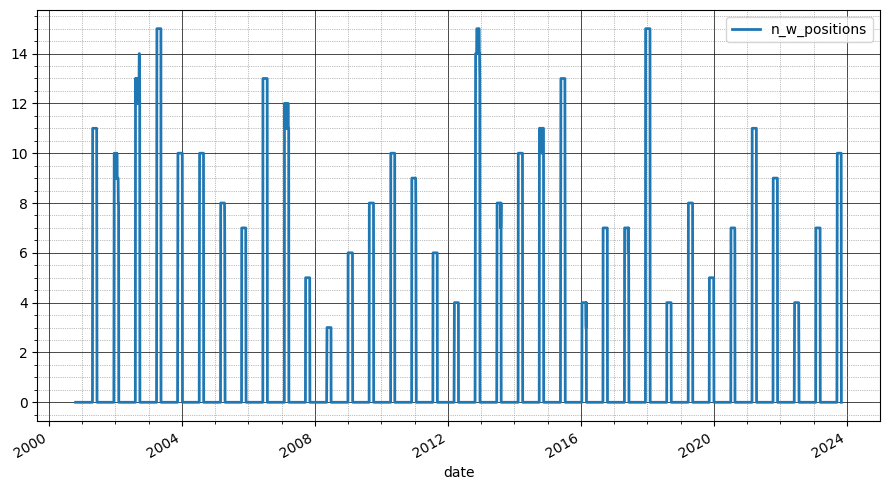

<Figure size 900x500 with 0 Axes>

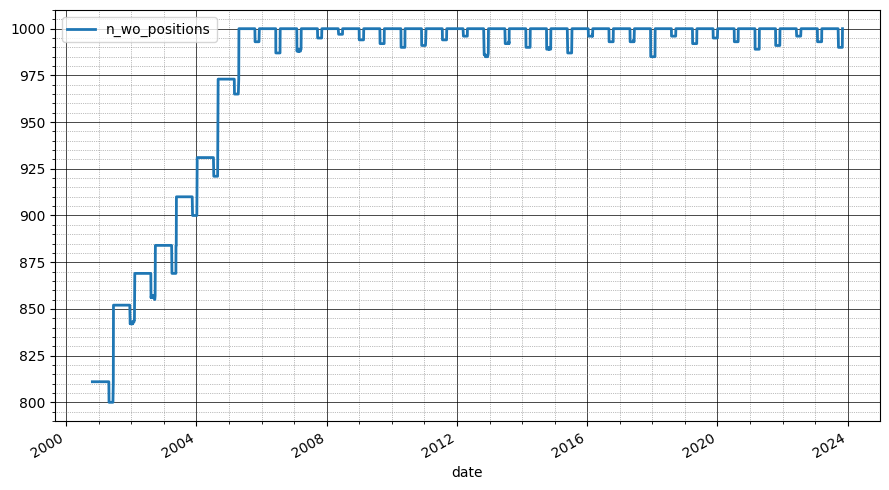

<Figure size 900x500 with 0 Axes>

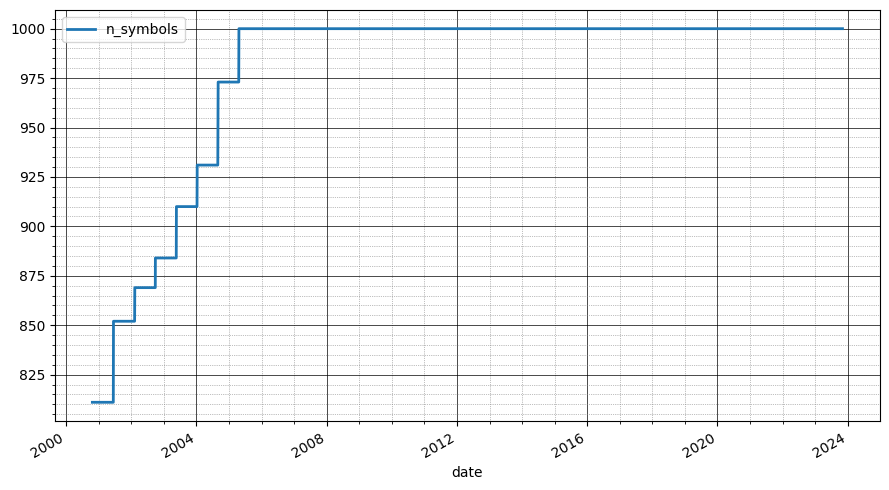

<Figure size 900x500 with 0 Axes>

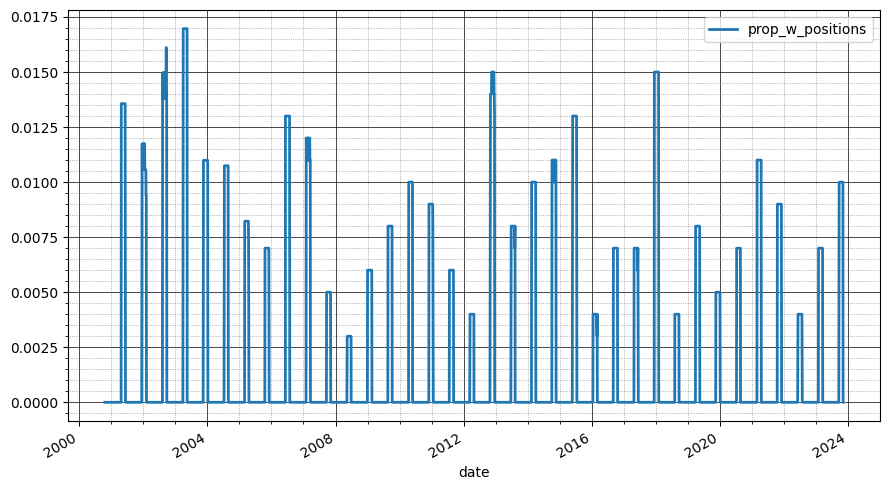

In [11]:
universe_index = universe.select(*keys).unique()
positions_index = weights.select(*keys).unique().with_columns(has_position=pl.lit(True))
assert positions_index.join(universe_index, on=keys, how='anti').is_empty()  # sanity check
n_positions = (
    universe_index
    .join(positions_index, on=keys, how='left')
    .fill_null(False)
    .sort(*keys)
)
sub = (
    n_positions
    .group_by('date', maintain_order=True)
    .agg([
        pl.col('has_position').sum().alias('n_w_positions'),
        pl.col('has_position').not_().sum().alias('n_wo_positions'),
        pl.len().alias('n_symbols'),
        (pl.col('has_position').sum() / pl.len()).alias('prop_w_positions'),
    ])
)

for col in sub.columns[1:]:
    plot_ts(sub.select('date', col), 'date')

In [12]:
joined = (
    universe
    .join(positions_index, on=keys, how='left')
    .with_columns(pl.col('has_position').fill_null(False))
    .select(*keys, 'batch', 'is_formation', 'has_position')
)
assert are_keys(joined, keys)[0]

(
    joined
    .group_by('is_formation', 'has_position')
    .len()
)

shape: (3, 3)
┌──────────────┬──────────────┬─────────┐
│ is_formation ┆ has_position ┆ len     │
│ ---          ┆ ---          ┆ ---     │
│ bool         ┆ bool         ┆ u32     │
╞══════════════╪══════════════╪═════════╡
│ true         ┆ false        ┆ 4438980 │
│ false        ┆ true         ┆ 10318   │
│ false        ┆ false        ┆ 1222732 │
└──────────────┴──────────────┴─────────┘

In [13]:
17160 / (129840 + 17160)

0.11673469387755102

In [14]:
batches = joined.group_by('is_formation', 'batch').agg([
    pl.col('date').min().name.prefix('min_'),
    pl.col('date').max().name.prefix('max_')
]).sort('min_date')
batches_dates = batches.select(date='min_date').with_columns(is_start=pl.lit(0.0))

<Axes: xlabel='date'>

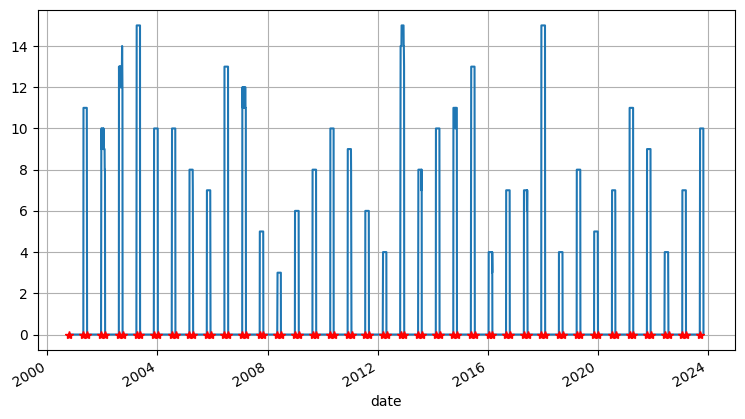

In [15]:
test = (
    sub
    .join(batches_dates, on='date', how='left')
    # .fill_null(False)
    .to_pandas()
    .set_index('date')
)
test['n_w_positions'].plot(grid=True)
test['is_start'].plot(marker='*', grid=True, color='r')

In [16]:
assert (
    joined
    .group_by('date')
    .agg(pl.col('is_formation').unique().len())
    .get_column('is_formation')
    .unique()
    .item()
) == 1

<Figure size 900x500 with 0 Axes>

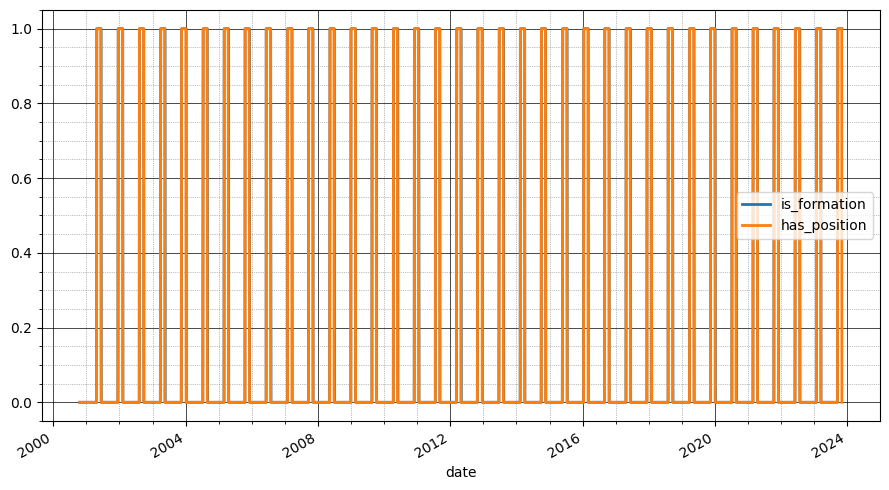

In [17]:
taken_positions = (
    joined
    .group_by('date', maintain_order=True)
    .agg([
        pl.col('is_formation').not_().first(),
        pl.col('has_position').any()
    ])
    .with_columns(pl.exclude('date').cast(pl.Float32))
)
plot_ts(taken_positions, 'date')

In [18]:
len(taken_positions.filter(pl.col('is_formation') != pl.col('has_position')))

72

# Are the positions different from one attempt to another?

## All weights

In [19]:
weights.select('weight').describe(percentiles=percentiles)

shape: (13, 2)
┌────────────┬──────────────┐
│ statistic  ┆ weight       │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 53481.0      │
│ null_count ┆ 0.0          │
│ mean       ┆ -0.740526    │
│ std        ┆ 24.927527    │
│ min        ┆ -1674.166409 │
│ …          ┆ …            │
│ 50%        ┆ -0.000149    │
│ 75%        ┆ 0.070615     │
│ 90%        ┆ 0.45844      │
│ 99%        ┆ 2.767345     │
│ max        ┆ 346.538455   │
└────────────┴──────────────┘

## One batch

In [20]:
full = universe.join(weights, on=keys, how='left')

In [21]:
thin = (
    full
    .filter(pl.col('batch') == 1)
    .filter(pl.col('is_formation').not_())
    .select([*keys, 'attempt', 'weight'])
)

<Figure size 900x500 with 0 Axes>

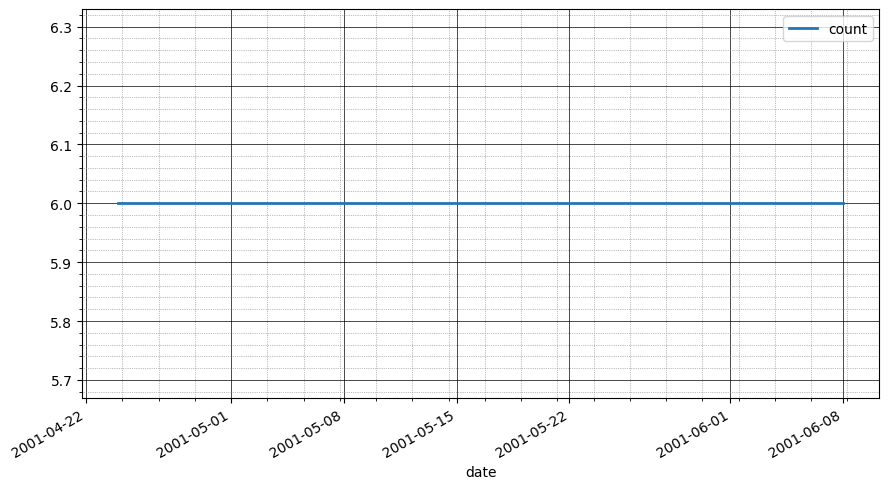

<Figure size 900x500 with 0 Axes>

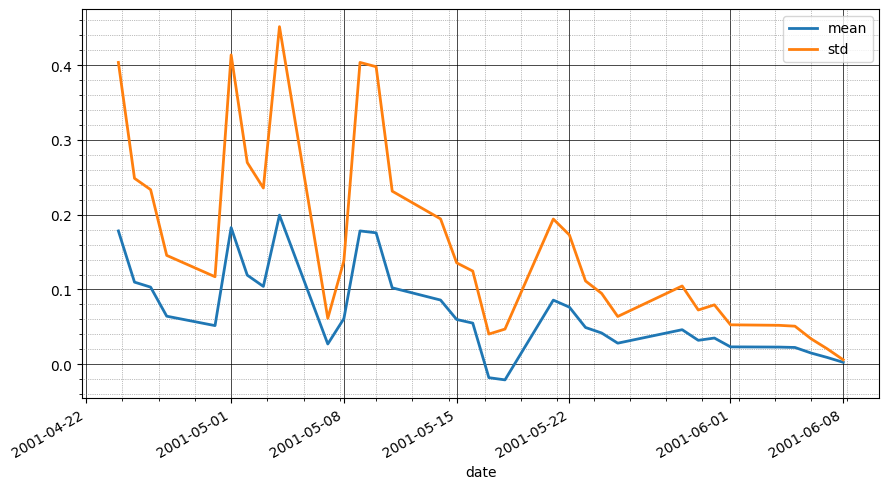

<Figure size 900x500 with 0 Axes>

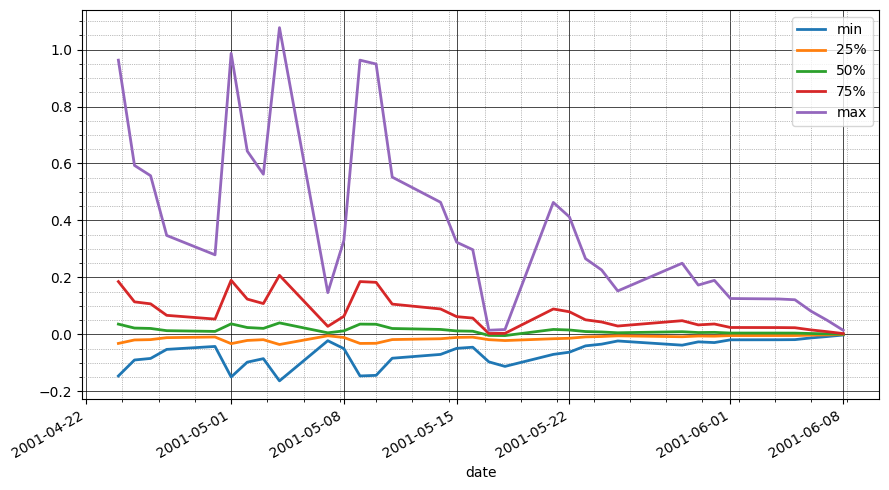

In [22]:
attempt = 0
one_attempt = thin.filter(pl.col('attempt') == attempt)
sub = pivot_to_pd(one_attempt, *keys, 'weight')
plot_desc_pfo_matrix(sub)

<Figure size 900x500 with 0 Axes>

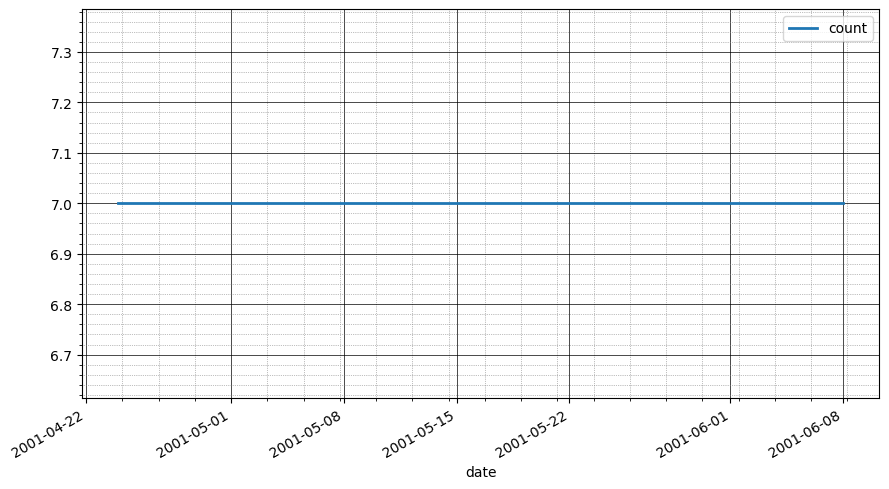

<Figure size 900x500 with 0 Axes>

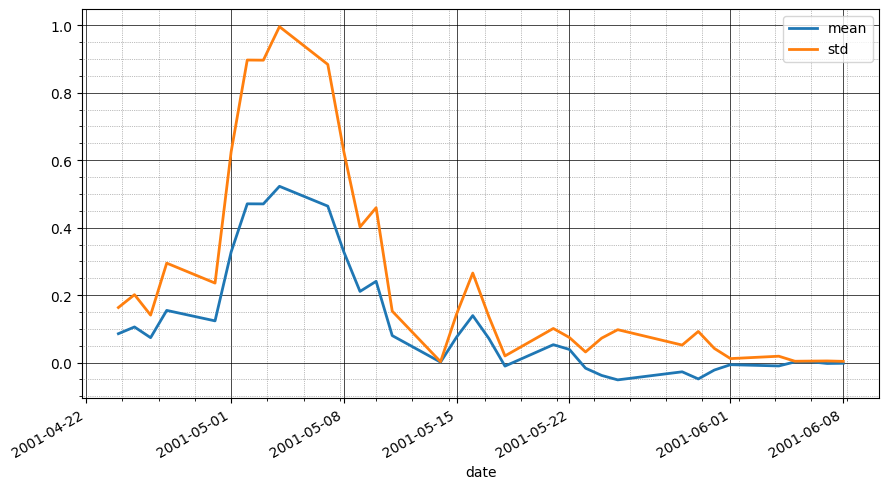

<Figure size 900x500 with 0 Axes>

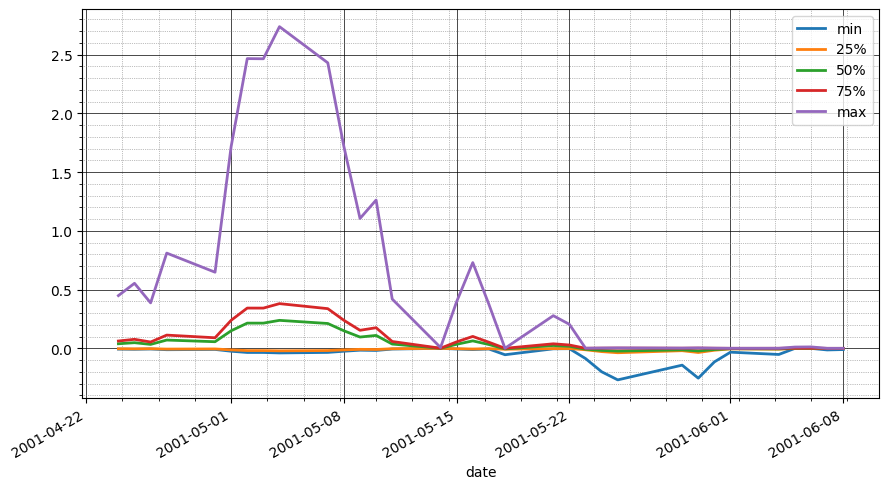

In [23]:
attempt = 1
one_attempt = thin.filter(pl.col('attempt') == attempt)
sub = pivot_to_pd(one_attempt, *keys, 'weight')
plot_desc_pfo_matrix(sub)

In [24]:
w_means = (
    thin
    .with_columns(mean_weight=pl.col('weight').mean().over(keys))
    .with_columns(demeaned_weight=pl.col('weight') - pl.col('mean_weight'))
)
w_means.select('demeaned_weight').describe()

shape: (9, 2)
┌────────────┬─────────────────┐
│ statistic  ┆ demeaned_weight │
│ ---        ┆ ---             │
│ str        ┆ f64             │
╞════════════╪═════════════════╡
│ count      ┆ 1748.0          │
│ null_count ┆ 28022.0         │
│ mean       ┆ -4.0649e-18     │
│ std        ┆ 0.076982        │
│ min        ┆ -1.003064       │
│ 25%        ┆ -0.007491       │
│ 50%        ┆ 0.000037        │
│ 75%        ┆ 0.009484        │
│ max        ┆ 0.469345        │
└────────────┴─────────────────┘

# Aggregate position through `attempt`

In [25]:
quantile = 0.01
attrs = ['mean', 'median', ('quantile', quantile), ('quantile', 1 - quantile), 'std']
getattr_cpl = lambda attr: (
    getattr(pl.col('demeaned_weight'), attr[0])(attr[1])
    if isinstance(attr, tuple) else
    getattr(pl.col('demeaned_weight'), attr)()
).over(keys).alias(f'{attr[0]}_{attr[1]}' if isinstance(attr, tuple) else attr)

w_quantiles = (
    full
    .select([*keys, 'attempt', 'weight'])
    .with_columns(demeaned_weight=pl.col('weight') - pl.col('weight').mean().over(keys))
    .with_columns(demedianed_weight=pl.col('weight') - pl.col('weight').median().over(keys))
    .with_columns([getattr_cpl(attr) for attr in attrs])
)

(
    w_quantiles
    .select('demeaned_weight', 'demedianed_weight')
    .describe(percentiles=percentiles)
)

shape: (13, 3)
┌────────────┬─────────────────┬───────────────────┐
│ statistic  ┆ demeaned_weight ┆ demedianed_weight │
│ ---        ┆ ---             ┆ ---               │
│ str        ┆ f64             ┆ f64               │
╞════════════╪═════════════════╪═══════════════════╡
│ count      ┆ 53481.0         ┆ 53481.0           │
│ null_count ┆ 5.661712e6      ┆ 5.661712e6        │
│ mean       ┆ 0.0             ┆ 0.182721          │
│ std        ┆ 13.662411       ┆ 14.76223          │
│ min        ┆ -795.62971      ┆ -559.731059       │
│ …          ┆ …               ┆ …                 │
│ 50%        ┆ 0.0             ┆ 0.0               │
│ 75%        ┆ 0.004778        ┆ 9.6473e-13        │
│ 90%        ┆ 0.101629        ┆ 0.053087          │
│ 99%        ┆ 1.545722        ┆ 1.410964          │
│ max        ┆ 747.136806      ┆ 1062.547175       │
└────────────┴─────────────────┴───────────────────┘

In [26]:
medianed = full.group_by(keys).median().sort(keys)
medianed.describe(percentiles=percentiles)

shape: (13, 12)
┌────────────┬────────────┬─────────┬────────────┬───┬─────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ date       ┆ symbol  ┆ price      ┆ … ┆ path    ┆ attempt   ┆ weight    ┆ path_righ │
│ ---        ┆ ---        ┆ ---     ┆ ---        ┆   ┆ ---     ┆ ---       ┆ ---       ┆ t         │
│ str        ┆ str        ┆ str     ┆ f64        ┆   ┆ str     ┆ f64       ┆ f64       ┆ ---       │
│            ┆            ┆         ┆            ┆   ┆         ┆           ┆           ┆ str       │
╞════════════╪════════════╪═════════╪════════════╪═══╪═════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 5672030    ┆ 5672030 ┆ 5.67203e6  ┆ … ┆ 0       ┆ 10318.0   ┆ 10318.0   ┆ 0         │
│ null_count ┆ 0          ┆ 0       ┆ 0.0        ┆ … ┆ 5672030 ┆ 5.661712e ┆ 5.661712e ┆ 5672030   │
│            ┆            ┆         ┆            ┆   ┆         ┆ 6         ┆ 6         ┆           │
│ mean       ┆ 2012-07-18 ┆ null    ┆ 432206.490 ┆ … ┆ null    ┆ 4.393681  ┆ -0.690457 ┆ null      │
│            ┆            ┆         ┆ 463        ┆   ┆         ┆           ┆           ┆           │
│ std        ┆ null       ┆ null    ┆ 6.0211e7   ┆ … ┆ null    ┆ 1.831198  ┆ 22.118857 ┆ null      │
│ min        ┆ 2000-10-20 ┆ AADR    ┆ 0.015      ┆ … ┆ null    ┆ 0.0       ┆ -1193.947 ┆ null      │
│            ┆            ┆         ┆            ┆   ┆         ┆           ┆ 068       ┆           │
│ …          ┆ …          ┆ …       ┆ …          ┆ … ┆ …       ┆ …         ┆ …         ┆ …         │
│ 50%        ┆ 2012-07-27 ┆ null    ┆ 20.003323  ┆ … ┆ null    ┆ 4.5       ┆ -0.000349 ┆ null      │
│ 75%        ┆ 2018-03-19 ┆ null    ┆ 45.029213  ┆ … ┆ null    ┆ 5.0       ┆ 0.05392   ┆ null      │
│ 90%        ┆ 2021-08-04 ┆ null    ┆ 104.889999 ┆ … ┆ null    ┆ 7.0       ┆ 0.386257  ┆ null      │
│ 99%        ┆ 2023-08-16 ┆ null    ┆ 10500.0    ┆ … ┆ null    ┆ 9.0       ┆ 2.584081  ┆ null      │
│ max        ┆ 2023-11-03 ┆ ZYXI    ┆ 2.0566e10  ┆ … ┆ null    ┆ 9.0       ┆ 101.77700 ┆ null      │
│            ┆            ┆         ┆            ┆   ┆         ┆           ┆ 8         ┆           │
└────────────┴────────────┴─────────┴────────────┴───┴─────────┴───────────┴───────────┴───────────┘

<Figure size 900x500 with 0 Axes>

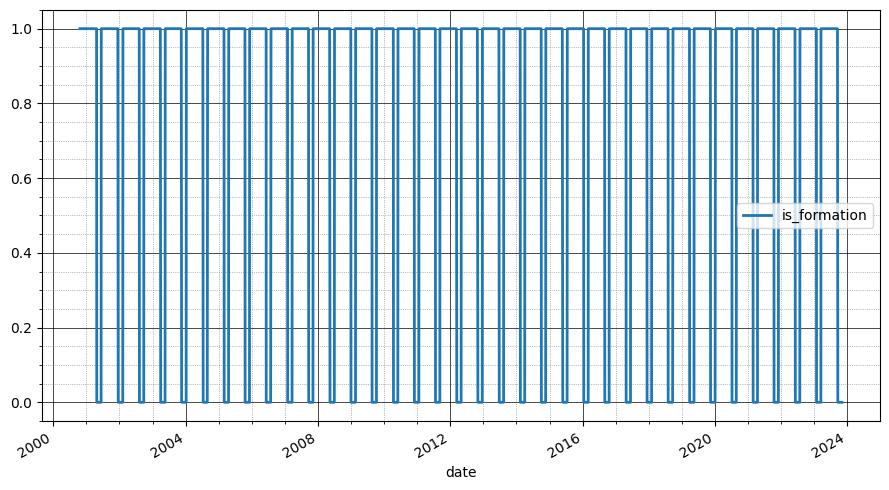

In [27]:
plot_ts(medianed.group_by(keys[0], maintain_order=True).agg(pl.col('is_formation').max()), 'date')

In [28]:
# medianed.group_by(keys[0], 'is_formation').len().group_by('date').agg(pl.col('is_formation').n_unique()).drop('date').unique()

In [29]:
normalized = (
    medianed
    .with_columns(is_trade_first_day=pl.col('date')==pl.col('date').min().over('batch', 'is_formation'))
    .with_columns(is_trade_first_day=pl.when(pl.col('is_formation') > 0.5).then(False).otherwise(pl.col('is_trade_first_day')))
    .with_columns(leverage_first_day=pl.col('weight').abs().sum().over('date'))
    .with_columns(leverage_first_day=pl.when(pl.col('is_trade_first_day').not_()).then(None).otherwise(pl.col('leverage_first_day')))
    .with_columns(pl.col('leverage_first_day').forward_fill().over('batch'))
    .with_columns(weight_normalized=pl.col('weight') / pl.col('leverage_first_day'))
)
assert have_same_nulls(normalized, 'weight', 'weight_normalized')

shape: (9, 15)
┌────────────┬────────────┬────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ date       ┆ symbol ┆ price     ┆ … ┆ path_righ ┆ is_trade_ ┆ leverage_ ┆ weight_no │
│ ---        ┆ ---        ┆ ---    ┆ ---       ┆   ┆ t         ┆ first_day ┆ first_day ┆ rmalized  │
│ str        ┆ str        ┆ str    ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆        ┆           ┆   ┆ str       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 363        ┆ 363    ┆ 363.0     ┆ … ┆ 0         ┆ 363.0     ┆ 363.0     ┆ 363.0     │
│ null_count ┆ 0          ┆ 0      ┆ 0.0       ┆ … ┆ 363       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 2001-05-16 ┆ null   ┆ 81.83835  ┆ … ┆ null      ┆ 0.030303  ┆ 1.757325  ┆ 0.045972  │
│ std        ┆ null       ┆ null   ┆ 139.02998 ┆ … ┆ null      ┆ null      ┆ 2.2235e-1 ┆ 0.219513  │
│            ┆            ┆        ┆ 7         ┆   ┆           ┆           ┆ 6         ┆           │
│ min        ┆ 2001-04-24 ┆ AGEN   ┆ 1.54      ┆ … ┆ null      ┆ 0.0       ┆ 1.757325  ┆ -0.765324 │
│ 25%        ┆ 2001-05-04 ┆ null   ┆ 3.31522   ┆ … ┆ null      ┆ null      ┆ 1.757325  ┆ -0.006435 │
│ 50%        ┆ 2001-05-16 ┆ null   ┆ 8.5125    ┆ … ┆ null      ┆ null      ┆ 1.757325  ┆ 0.000056  │
│ 75%        ┆ 2001-05-29 ┆ null   ┆ 100.98135 ┆ … ┆ null      ┆ null      ┆ 1.757325  ┆ 0.02621   │
│            ┆            ┆        ┆ 4         ┆   ┆           ┆           ┆           ┆           │
│ max        ┆ 2001-06-08 ┆ VTNR   ┆ 571.90283 ┆ … ┆ null      ┆ 1.0       ┆ 1.757325  ┆ 1.653038  │
│            ┆            ┆        ┆ 2         ┆   ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

<Figure size 900x500 with 0 Axes>

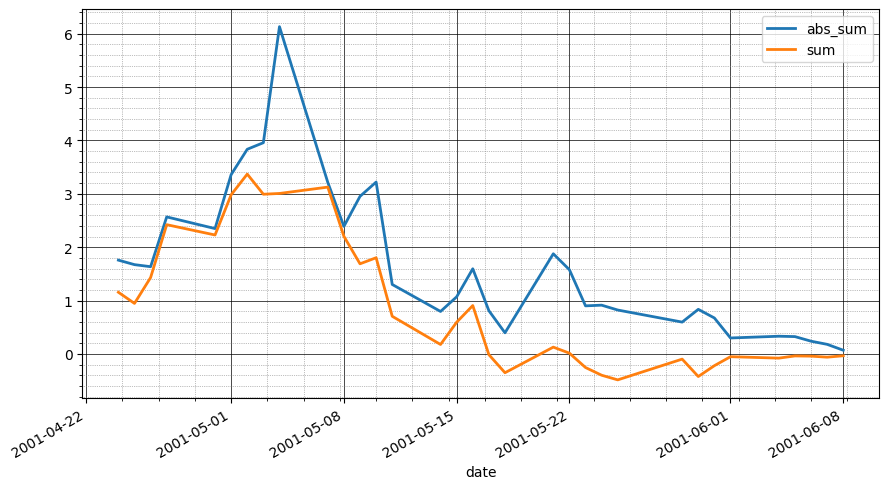

<Figure size 900x500 with 0 Axes>

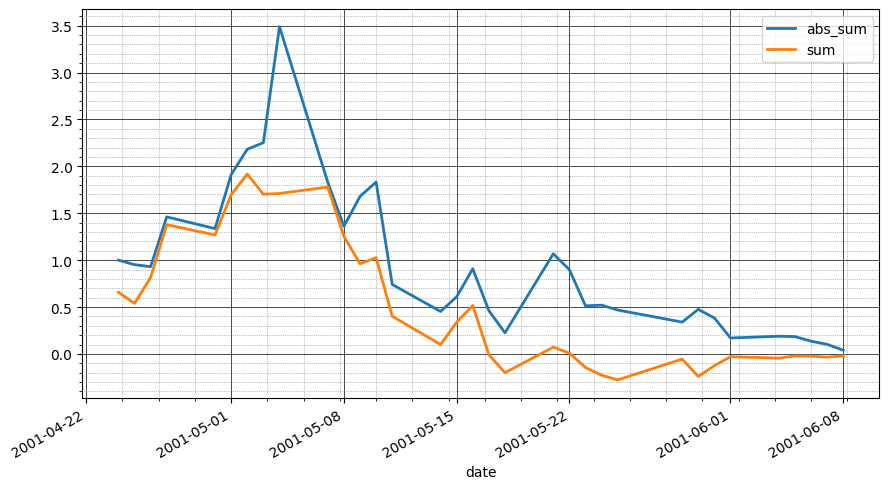

shape: (9, 15)
┌────────────┬────────────┬────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ date       ┆ symbol ┆ price     ┆ … ┆ path_righ ┆ is_trade_ ┆ leverage_ ┆ weight_no │
│ ---        ┆ ---        ┆ ---    ┆ ---       ┆   ┆ t         ┆ first_day ┆ first_day ┆ rmalized  │
│ str        ┆ str        ┆ str    ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆        ┆           ┆   ┆ str       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 309        ┆ 309    ┆ 309.0     ┆ … ┆ 0         ┆ 309.0     ┆ 309.0     ┆ 309.0     │
│ null_count ┆ 0          ┆ 0      ┆ 0.0       ┆ … ┆ 309       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 2002-01-09 ┆ null   ┆ 14192.970 ┆ … ┆ null      ┆ 0.032362  ┆ 104.83384 ┆ -0.210469 │
│            ┆            ┆        ┆ 957       ┆   ┆           ┆           ┆ 4         ┆           │
│ std        ┆ null       ┆ null   ┆ 40443.477 ┆ … ┆ null      ┆ null      ┆ 1.4234e-1 ┆ 1.202078  │
│            ┆            ┆        ┆ 788       ┆   ┆           ┆           ┆ 4         ┆           │
│ min        ┆ 2001-12-17 ┆ AWH    ┆ 0.026892  ┆ … ┆ null      ┆ 0.0       ┆ 104.83384 ┆ -11.38894 │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆ 4         ┆ 7         │
│ 25%        ┆ 2001-12-28 ┆ null   ┆ 2.0       ┆ … ┆ null      ┆ null      ┆ 104.83384 ┆ -0.000612 │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆ 4         ┆           │
│ 50%        ┆ 2002-01-09 ┆ null   ┆ 16.5      ┆ … ┆ null      ┆ null      ┆ 104.83384 ┆ -0.000003 │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆ 4         ┆           │
│ 75%        ┆ 2002-01-23 ┆ null   ┆ 795.0     ┆ … ┆ null      ┆ null      ┆ 104.83384 ┆ 0.000074  │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆ 4         ┆           │
│ max        ┆ 2002-02-04 ┆ TTNP   ┆ 200486.18 ┆ … ┆ null      ┆ 1.0       ┆ 104.83384 ┆ 0.970841  │
│            ┆            ┆        ┆ 75        ┆   ┆           ┆           ┆ 4         ┆           │
└────────────┴────────────┴────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

<Figure size 900x500 with 0 Axes>

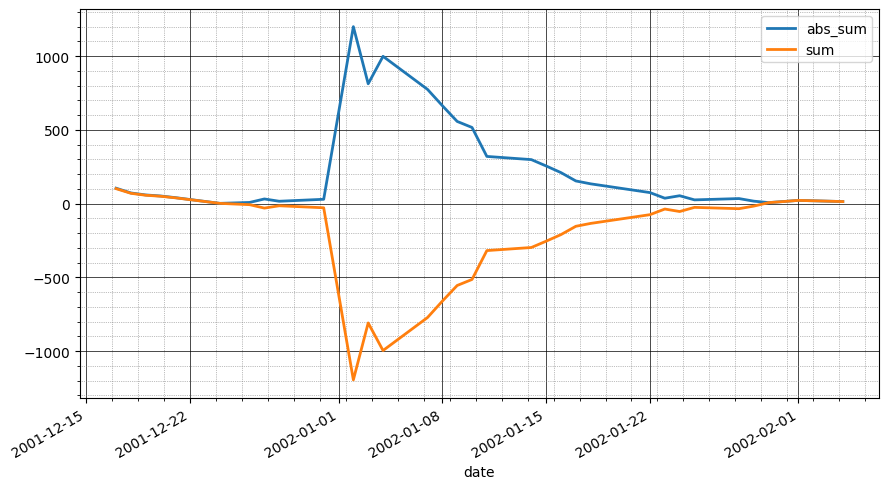

<Figure size 900x500 with 0 Axes>

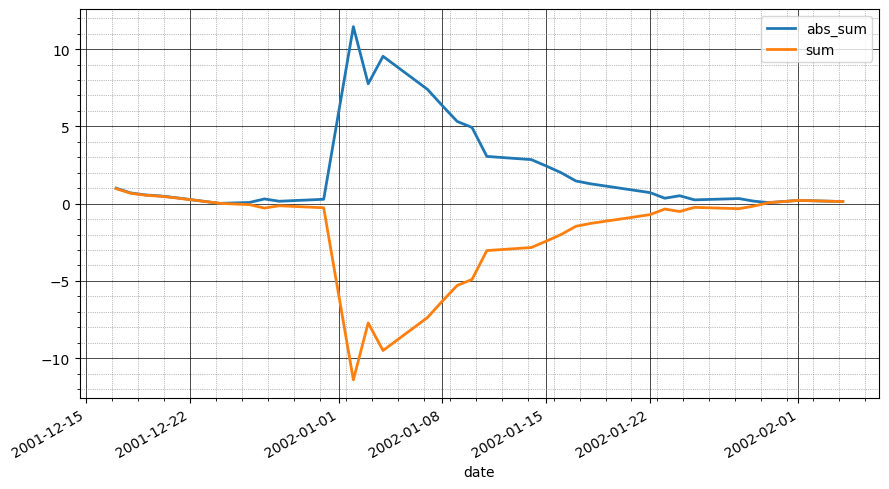

In [30]:
for batch in [1, 2]:
    sub = normalized.filter(pl.col('batch') == batch).drop_nulls('weight')
    display(sub.describe())
    
    plot_ts(
        sub.group_by('date', maintain_order=True).agg(
            abs_sum=pl.col('weight').abs().sum(),
            sum=pl.col('weight').sum(),
        ),
        'date')
    
    plot_ts(
        sub.group_by('date', maintain_order=True).agg(
            abs_sum=pl.col('weight_normalized').abs().sum(),
            sum=pl.col('weight_normalized').sum(),
        ),
        'date')

shape: (13, 2)
┌────────────┬───────────────────┐
│ statistic  ┆ weight_normalized │
│ ---        ┆ ---               │
│ str        ┆ f64               │
╞════════════╪═══════════════════╡
│ count      ┆ 10318.0           │
│ null_count ┆ 5.661712e6        │
│ mean       ┆ -0.016446         │
│ std        ┆ 0.528089          │
│ min        ┆ -11.388947        │
│ …          ┆ …                 │
│ 50%        ┆ -0.000087         │
│ 75%        ┆ 0.028873          │
│ 90%        ┆ 0.193956          │
│ 99%        ┆ 1.424891          │
│ max        ┆ 4.596             │
└────────────┴───────────────────┘

<Figure size 900x500 with 0 Axes>

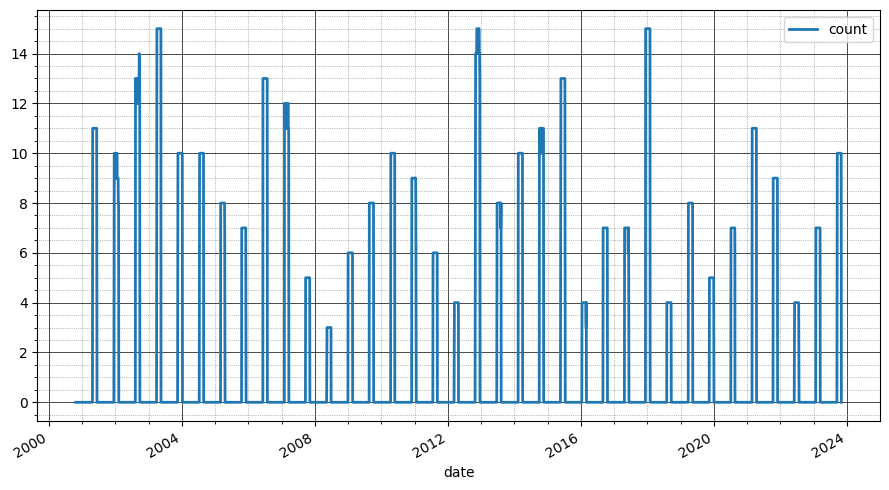

<Figure size 900x500 with 0 Axes>

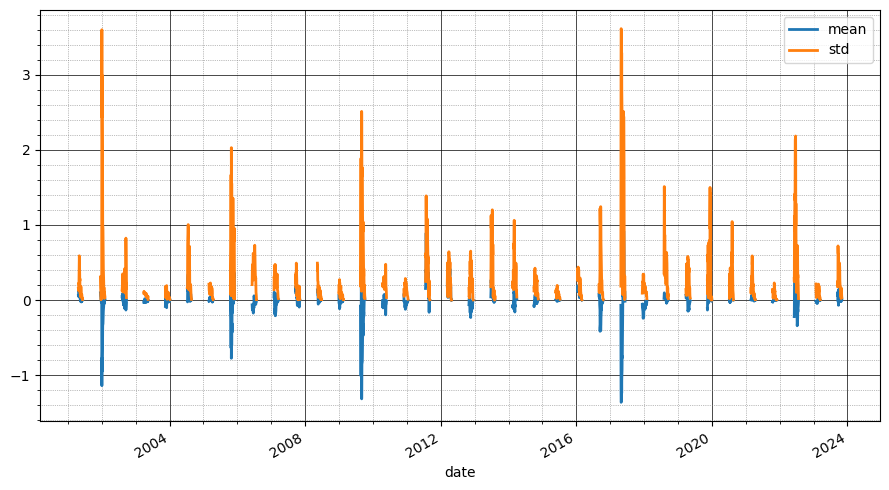

<Figure size 900x500 with 0 Axes>

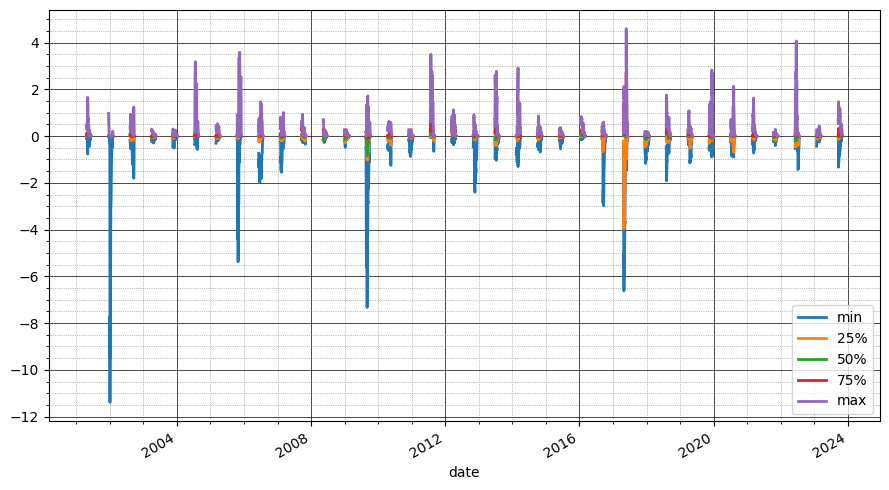

In [31]:
t_s = (
    normalized
    .filter(pl.len().over(keys[0]) > 1)  # at least two positions!
    .sort(keys)
)
sub = pivot_to_pd(t_s, *keys, 'weight_normalized')
display(t_s.select('weight_normalized').describe(percentiles=percentiles))
plot_desc_pfo_matrix(sub)

shape: (13, 2)
┌────────────┬──────────────┐
│ statistic  ┆ weight       │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 10318.0      │
│ null_count ┆ 5.661712e6   │
│ mean       ┆ -0.690457    │
│ std        ┆ 22.118857    │
│ min        ┆ -1193.947068 │
│ …          ┆ …            │
│ 50%        ┆ -0.000349    │
│ 75%        ┆ 0.05392      │
│ 90%        ┆ 0.386257     │
│ 99%        ┆ 2.584081     │
│ max        ┆ 101.777008   │
└────────────┴──────────────┘

<Figure size 900x500 with 0 Axes>

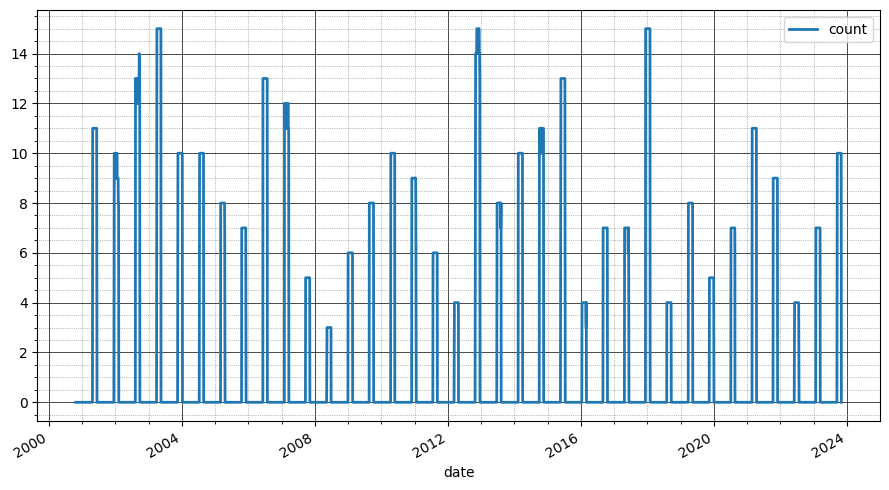

<Figure size 900x500 with 0 Axes>

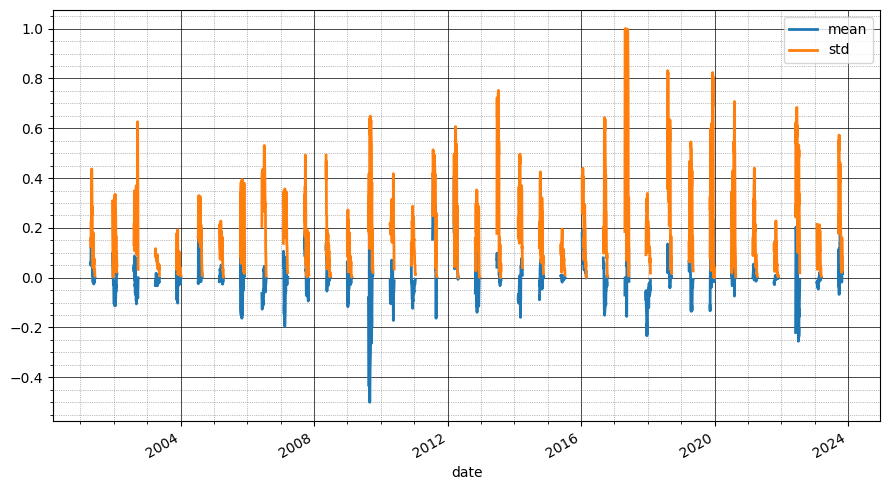

<Figure size 900x500 with 0 Axes>

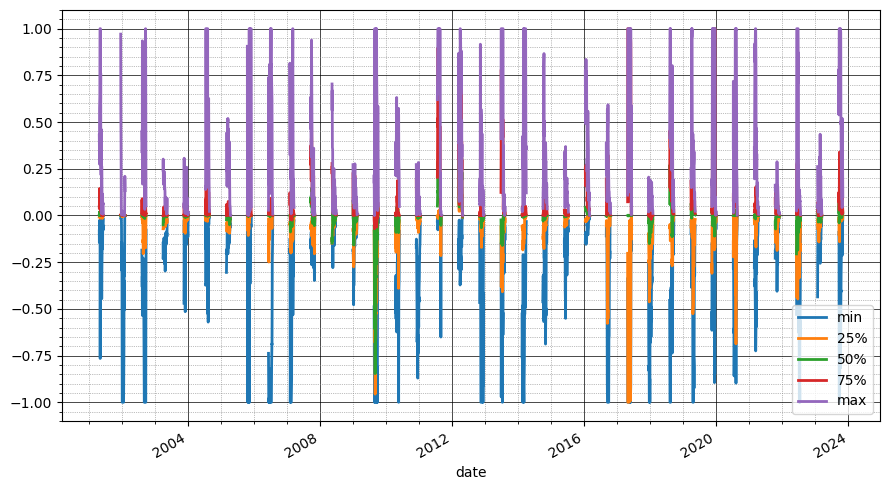

In [32]:
clip = 1
t_s = (
    normalized
    .filter(pl.len().over(keys[0]) > 1)  # at least two positions!
    .with_columns(pl.col('weight_normalized').clip(-clip, clip))
    .sort(keys)
)
sub = pivot_to_pd(t_s, *keys, 'weight_normalized')
display(t_s.select('weight').describe(percentiles=percentiles))
plot_desc_pfo_matrix(sub)

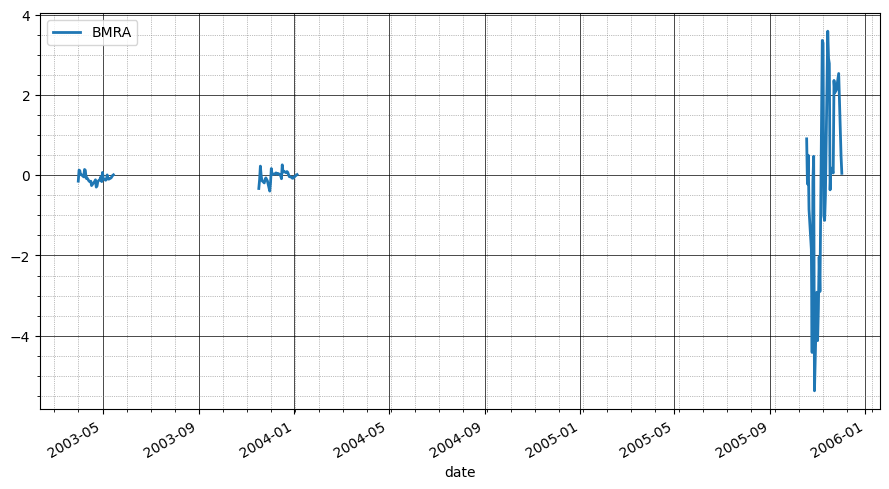

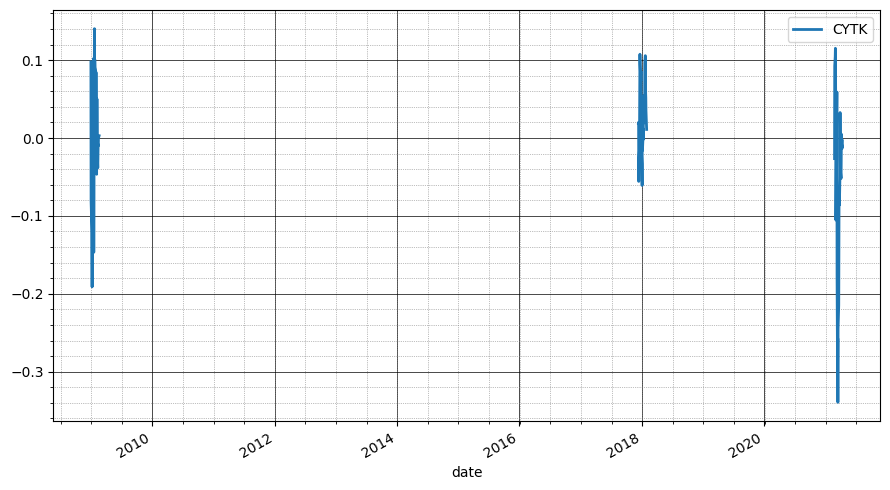

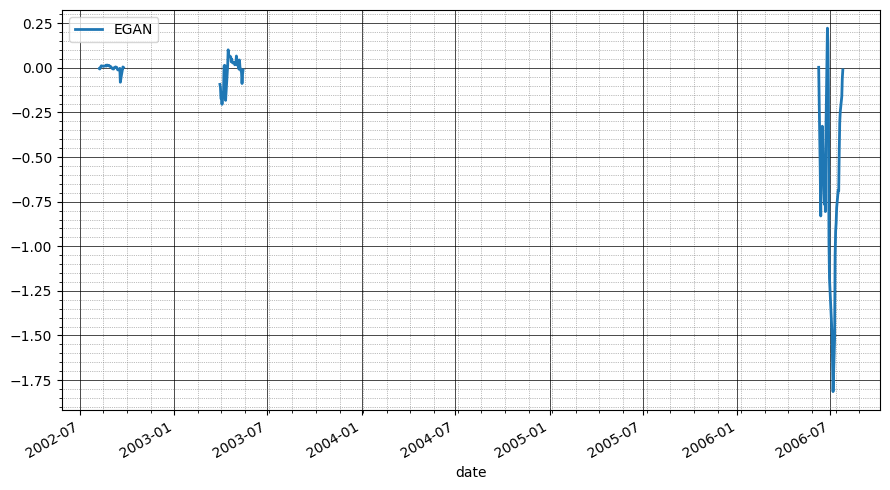

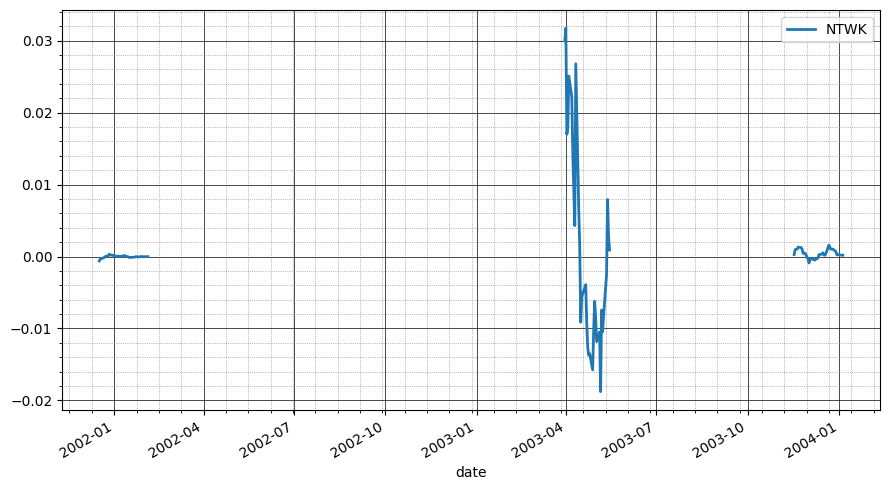

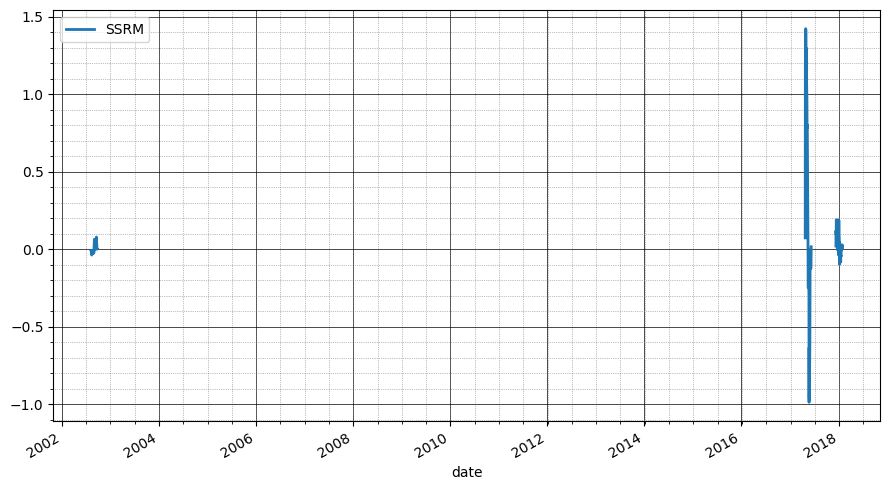

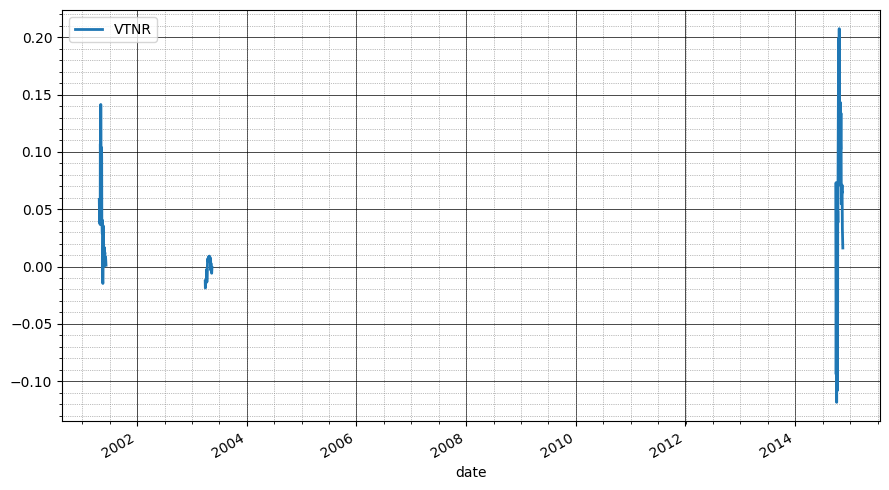

In [33]:
pivoted = pivot_to_pd(normalized, *keys, 'weight_normalized').dropna(axis=1, how='all')
biggest_coverage = pivoted.notna().sum() == pivoted.notna().sum().max()
for symbol in biggest_coverage.loc[lambda x: x].index:
    plot_pd_frame(pivoted[symbol])

# Aggregate positions for one hyperparameter

## Number of positions per date

In [34]:
hyperparameters = index.drop('start_date', 'path').unique()
hyperparameters.describe()

shape: (9, 4)
┌────────────┬──────────────────┬───────────┬────────────┐
│ statistic  ┆ formation_length ┆ t_max     ┆ n_stocks   │
│ ---        ┆ ---              ┆ ---       ┆ ---        │
│ str        ┆ f64              ┆ f64       ┆ f64        │
╞════════════╪══════════════════╪═══════════╪════════════╡
│ count      ┆ 54.0             ┆ 54.0      ┆ 54.0       │
│ null_count ┆ 0.0              ┆ 0.0       ┆ 0.0        │
│ mean       ┆ 81.666667        ┆ 29.333333 ┆ 370.0      │
│ std        ┆ 36.638983        ┆ 30.003773 ┆ 451.187113 │
│ min        ┆ 42.0             ┆ 5.0       ┆ 10.0       │
│ 25%        ┆ 42.0             ┆ 10.0      ┆ 10.0       │
│ 50%        ┆ 63.0             ┆ 21.0      ┆ 100.0      │
│ 75%        ┆ 126.0            ┆ 42.0      ┆ 1000.0     │
│ max        ┆ 126.0            ┆ 126.0     ┆ 1000.0     │
└────────────┴──────────────────┴───────────┴────────────┘

In [35]:
hyper_dict = hyperparameters.row(0, named=True)
hyper_dict

{'formation_length': 42, 't_max': 10, 'n_stocks': 100}

In [36]:
hyper = pl.DataFrame(hyper_dict)
paths = index.join(hyper, on=hyper.columns)
paths

shape: (4, 5)
┌──────────────────┬───────┬──────────┬────────────┬───────────────────────────────────┐
│ formation_length ┆ t_max ┆ n_stocks ┆ start_date ┆ path                              │
│ ---              ┆ ---   ┆ ---      ┆ ---        ┆ ---                               │
│ i64              ┆ i64   ┆ i64      ┆ date       ┆ str                               │
╞══════════════════╪═══════╪══════════╪════════════╪═══════════════════════════════════╡
│ 42               ┆ 10    ┆ 100      ┆ 2000-01-03 ┆ simus_with_more_shifts/16.parque… │
│ 42               ┆ 10    ┆ 100      ┆ 2000-02-02 ┆ simus_with_more_shifts/17.parque… │
│ 42               ┆ 10    ┆ 100      ┆ 2000-03-03 ┆ simus_with_more_shifts/18.parque… │
│ 42               ┆ 10    ┆ 100      ┆ 2000-04-03 ┆ simus_with_more_shifts/19.parque… │
└──────────────────┴───────┴──────────┴────────────┴───────────────────────────────────┘

{'formation_length': 42, 't_max': 10, 'n_stocks': 100, 'start_date': datetime.date(2000, 1, 3), 'path': 'simus_with_more_shifts/16.parquet'}
10


<Figure size 900x500 with 0 Axes>

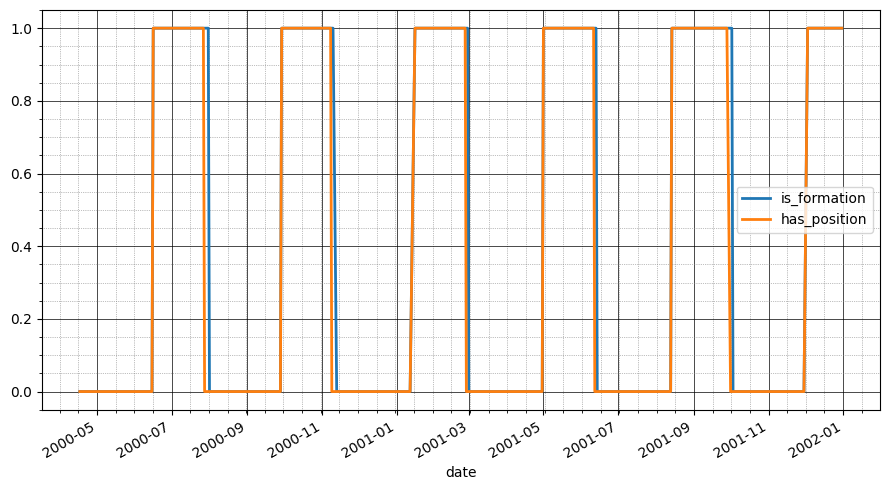

{'formation_length': 42, 't_max': 10, 'n_stocks': 100, 'start_date': datetime.date(2000, 2, 2), 'path': 'simus_with_more_shifts/17.parquet'}
10


<Figure size 900x500 with 0 Axes>

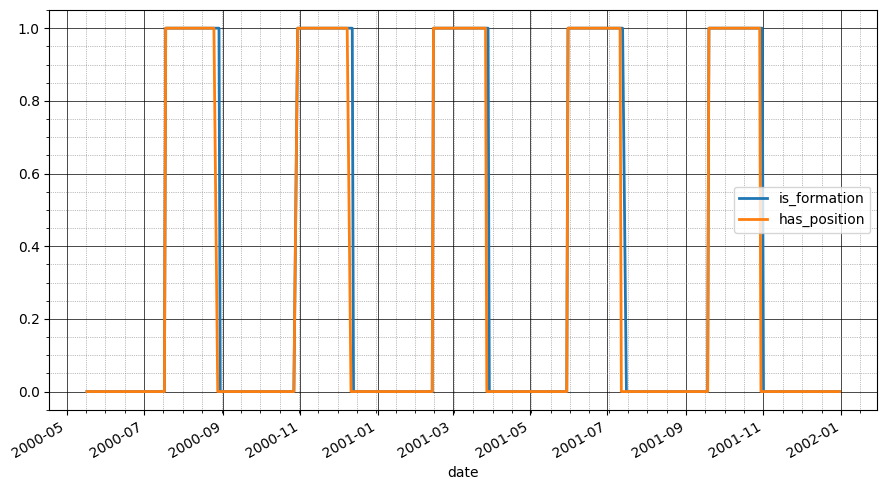

{'formation_length': 42, 't_max': 10, 'n_stocks': 100, 'start_date': datetime.date(2000, 3, 3), 'path': 'simus_with_more_shifts/18.parquet'}
10


<Figure size 900x500 with 0 Axes>

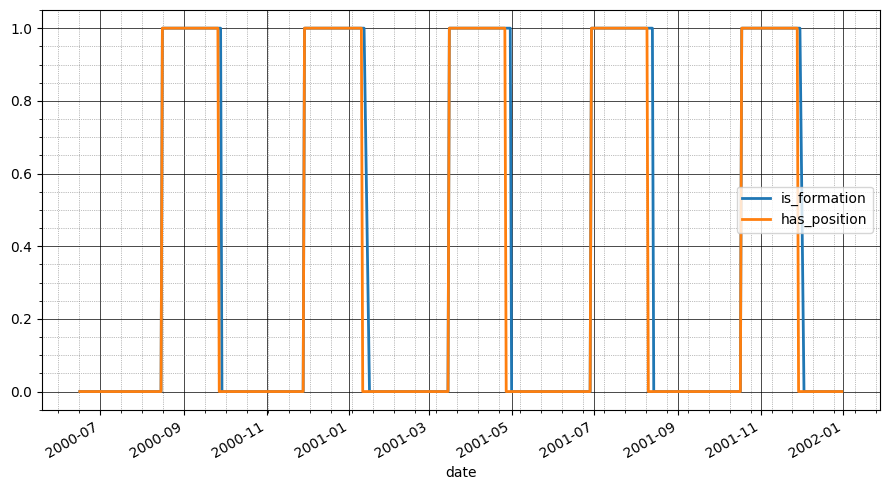

{'formation_length': 42, 't_max': 10, 'n_stocks': 100, 'start_date': datetime.date(2000, 4, 3), 'path': 'simus_with_more_shifts/19.parquet'}
9


<Figure size 900x500 with 0 Axes>

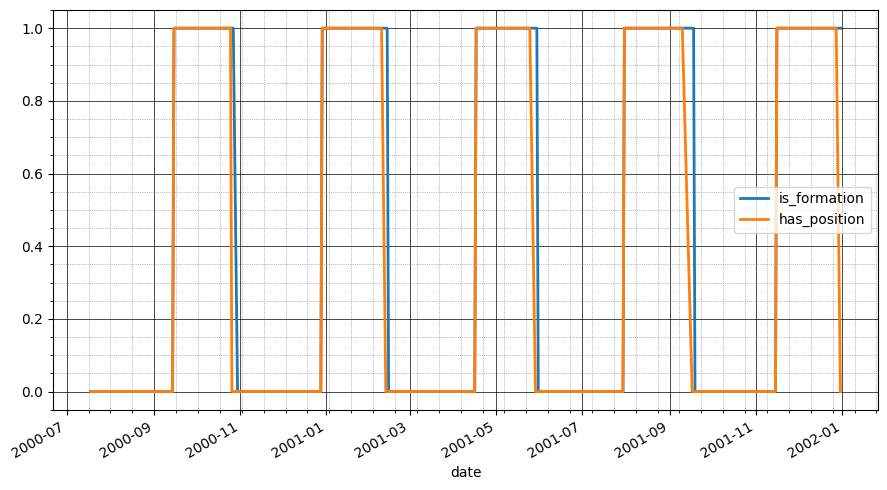

In [37]:
for path_run in paths.get_column('path'):
    params, weights, universe = read_data_one_run(path_run, path_index)
    print(params)
    weights = weights.group_by(keys).agg(pl.col('weight').median()).sort(keys)
    
    universe_index = universe.select(*keys).unique()
    positions_index = weights.select(*keys).unique().with_columns(has_position=pl.lit(True))
    # assert positions_index.join(universe_index, on=keys, how='anti').is_empty()  # sanity check
    n_positions = (
        universe_index
        .join(positions_index, on=keys, how='left')
        .fill_null(False)
        .sort(*keys)
    )
    sub = (
        n_positions
        .group_by('date', maintain_order=True)
        .agg([
            pl.col('has_position').sum().alias('n_w_positions'),
            pl.col('has_position').not_().sum().alias('n_wo_positions'),
            pl.len().alias('n_symbols'),
            (pl.col('has_position').sum() / pl.len()).alias('prop_w_positions'),
        ])
    )
    
    
    joined = (
        universe
        .join(positions_index, on=keys, how='left')
        .with_columns(pl.col('has_position').fill_null(False))
        .select(*keys, 'is_formation', 'has_position')
    )

    joined = joined.filter(pl.col('date') <= date(2002, 1, 1)).collect()
    
    assert (
        joined
        .group_by('date')
        .agg(pl.col('is_formation').unique().len())
        .get_column('is_formation')
        .unique()
        .item()
    ) == 1
    
    taken_positions = (
        joined
        .group_by('date', maintain_order=True)
        .agg([
            pl.col('is_formation').not_().first(),
            pl.col('has_position').any()
        ])
        .with_columns(pl.exclude('date').cast(pl.Float32))
    )
    print(len(taken_positions.filter(pl.col('is_formation') != pl.col('has_position'))))
    plot_ts(taken_positions, 'date')

In [38]:
universes = []
weights = []
for path_run in paths.get_column('path'):
    _, wghts, universe = read_data_one_run(path_run, path_index)
    universes.append(universe)
    weights.append(wghts.group_by(keys).agg(pl.col('weight').median()))

In [39]:
weights = pl.concat(weights).collect().sort(keys)

In [40]:
weights.group_by(keys).len().describe(percentiles=percentiles)

shape: (13, 4)
┌────────────┬────────────┬────────┬──────────┐
│ statistic  ┆ date       ┆ symbol ┆ len      │
│ ---        ┆ ---        ┆ ---    ┆ ---      │
│ str        ┆ str        ┆ str    ┆ f64      │
╞════════════╪════════════╪════════╪══════════╡
│ count      ┆ 22795      ┆ 22795  ┆ 22795.0  │
│ null_count ┆ 0          ┆ 0      ┆ 0.0      │
│ mean       ┆ 2012-03-19 ┆ null   ┆ 1.058302 │
│ std        ┆ null       ┆ null   ┆ 0.234319 │
│ min        ┆ 2000-06-16 ┆ AAL    ┆ 1.0      │
│ …          ┆ …          ┆ …      ┆ …        │
│ 50%        ┆ 2012-03-05 ┆ null   ┆ 1.0      │
│ 75%        ┆ 2017-12-21 ┆ null   ┆ 1.0      │
│ 90%        ┆ 2021-07-13 ┆ null   ┆ 1.0      │
│ 99%        ┆ 2024-01-11 ┆ null   ┆ 2.0      │
│ max        ┆ 2024-04-01 ┆ ZM     ┆ 2.0      │
└────────────┴────────────┴────────┴──────────┘

In [41]:
universe = (
    pl.concat(universes)
    .group_by(keys)
    .agg([
        pl.col('price', 'volume').first(),
        pl.col('volume_smoothed').mean(),
        pl.col('is_formation').all(),
    ])
    .sort(keys)
    .collect()
)

<Figure size 900x500 with 0 Axes>

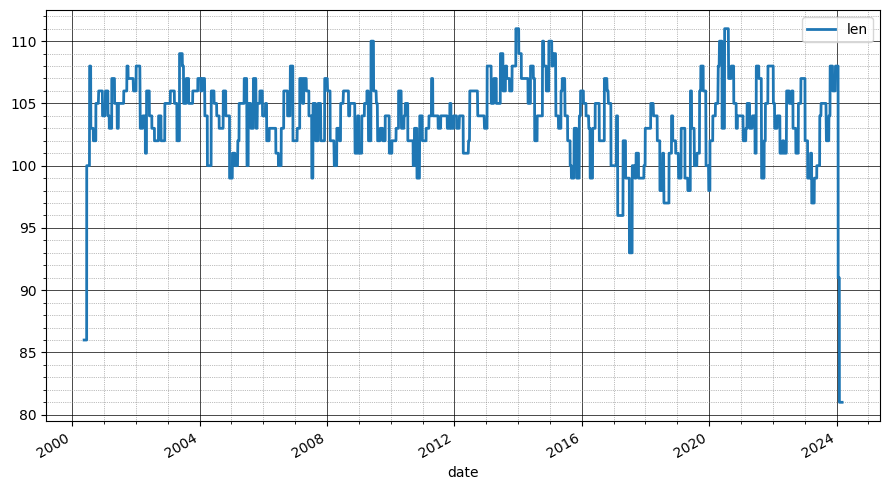

In [42]:
universe_intersection = (
    pl.concat(universes)
    .filter(pl.len().over(keys) > 1)
    .group_by(keys)
    .agg([
        pl.col('price', 'volume').first(),
        pl.col('volume_smoothed').mean(),
        pl.col('is_formation').all(),
    ])
    .sort(keys)
    .collect()
)
counts = universe_intersection.group_by(keys[0]).len().sort(keys[0])
plot_ts(counts, keys[0])

In [43]:
universe.select('date', 'is_formation').describe()

shape: (9, 3)
┌────────────┬────────────┬──────────────┐
│ statistic  ┆ date       ┆ is_formation │
│ ---        ┆ ---        ┆ ---          │
│ str        ┆ str        ┆ f64          │
╞════════════╪════════════╪══════════════╡
│ count      ┆ 801121     ┆ 801121.0     │
│ null_count ┆ 0          ┆ 0.0          │
│ mean       ┆ 2012-06-11 ┆ 0.174688     │
│ std        ┆ null       ┆ null         │
│ min        ┆ 2000-04-17 ┆ 0.0          │
│ 25%        ┆ 2006-06-13 ┆ null         │
│ 50%        ┆ 2012-08-08 ┆ null         │
│ 75%        ┆ 2018-06-11 ┆ null         │
│ max        ┆ 2024-04-03 ┆ 1.0          │
└────────────┴────────────┴──────────────┘

44


<Figure size 900x500 with 0 Axes>

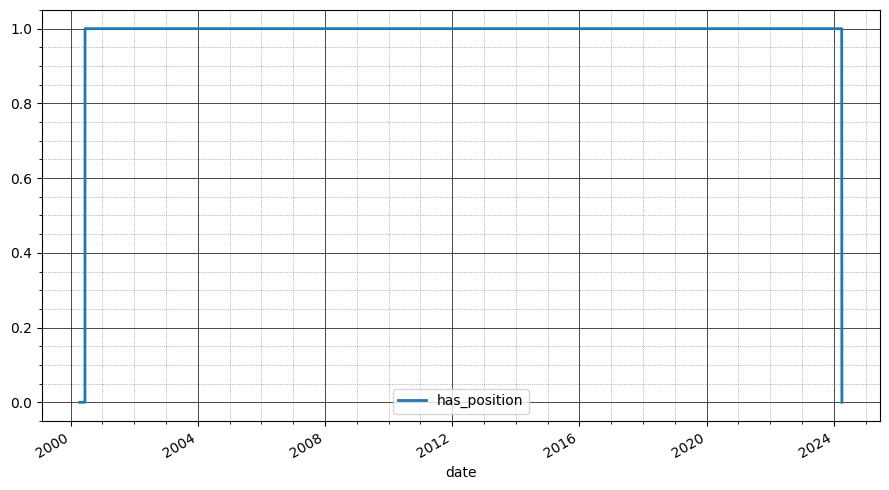

In [44]:
universe_index = universe.select(*keys).unique()
positions_index = weights.select(*keys).unique().with_columns(has_position=pl.lit(True))
# assert positions_index.join(universe_index, on=keys, how='anti').is_empty()  # sanity check
n_positions = (
    universe_index
    .join(positions_index, on=keys, how='left')
    .fill_null(False)
    .sort(*keys)
)
sub = (
    n_positions
    .group_by('date', maintain_order=True)
    .agg([
        pl.col('has_position').sum().alias('n_w_positions'),
        pl.col('has_position').not_().sum().alias('n_wo_positions'),
        pl.len().alias('n_symbols'),
        (pl.col('has_position').sum() / pl.len()).alias('prop_w_positions'),
    ])
)


joined = (
    universe
    .join(positions_index, on=keys, how='left')
    .with_columns(pl.col('has_position').fill_null(False))
    .select(*keys, 'is_formation', 'has_position')
)

taken_positions = (
    joined
    .group_by('date', maintain_order=True)
    .agg([
        pl.col('has_position').any()
    ])
    .with_columns(pl.exclude('date').cast(pl.Float32))
)
print(len(taken_positions.filter(pl.col('has_position') < 1)))
plot_ts(taken_positions, 'date')

## Porportions of positions per date

In [45]:
def read_data_one_run(path_run, path_index):
    path_run = Path(path_run)

    params = (
        pl.scan_parquet(Path(path_index))
        .filter(pl.col('path') == str(path_run))
        .collect()
    )
    assert len(params) == 1
    params = params.row(0, named=True)

    path_universe = path_run.parent / f'universe_{path_run.stem}.parquet'
    return params, pl.scan_parquet(path_run), pl.scan_parquet(path_universe)

In [46]:
paths = (
    pl.read_parquet(path_index)
    .join(pl.DataFrame(hyper_dict), on=list(hyper_dict))
    .get_column('path')
)
universes = []
weights = []
for path_run in paths:
    _, wghts, universe = read_data_one_run(path_run, path_index)
    # assert wghts.join(universe, on=keys, how='anti').is_empty()
    universes.append(universe)
    medianed = wghts.group_by(keys).agg(pl.col('weight').median())
    normalized = (
        universe
        .join(medianed, on=keys, how='inner')
        .with_columns(is_trade_first_day=(
            pl.col('date')==pl.col('date').min().over('batch', 'is_formation')
        ))
        .with_columns(is_trade_first_day=(
            pl.when(pl.col('is_formation') > 0.5)
            .then(False)
            .otherwise(pl.col('is_trade_first_day'))
        ))
        .with_columns(leverage_first_day=pl.col('weight').abs().sum().over('date'))
        .with_columns(leverage_first_day=(
            pl.when(pl.col('is_trade_first_day').not_())
            .then(None)
            .otherwise(pl.col('leverage_first_day'))
        ))
        .with_columns(pl.col('leverage_first_day').forward_fill().over('batch'))
        .with_columns(weight_normalized=pl.col('weight') / pl.col('leverage_first_day'))
        .select(*keys, 'weight', 'weight_normalized')
        .sort(keys)
    )
    weights.append(normalized)

In [47]:
universe = universes[-1].collect()
wghts = weights[-1].collect()
print(universe.columns, wghts.columns)

['date', 'symbol', 'price', 'volume', 'volume_smoothed', 'batch', 'is_formation', 'path'] ['date', 'symbol', 'weight', 'weight_normalized']


In [48]:
weights = pl.concat(weights).collect()
universes = pl.concat(universes).collect()

In [49]:
assert have_same_nulls(weights, 'weight', 'weight_normalized')
assert weights.null_count().sum_horizontal().item() == 0

In [50]:
weights.shape, universes.shape

((24124, 4), (2387100, 8))

<Figure size 900x500 with 0 Axes>

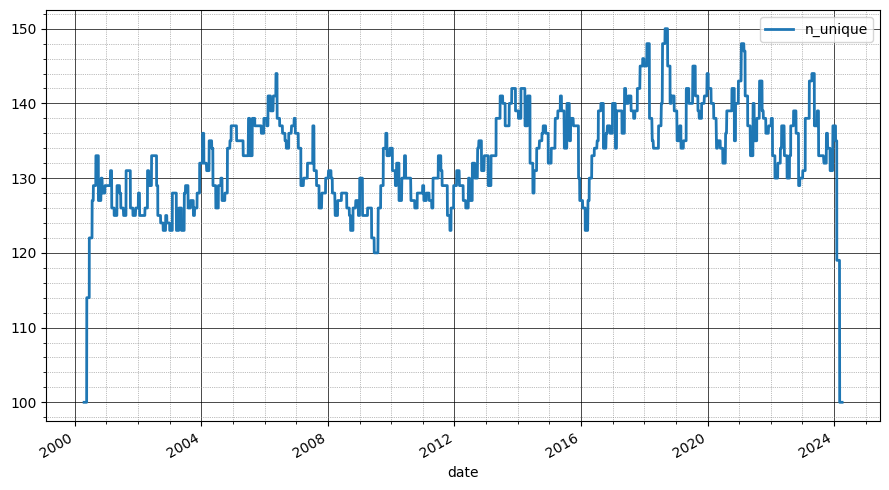

<Figure size 900x500 with 0 Axes>

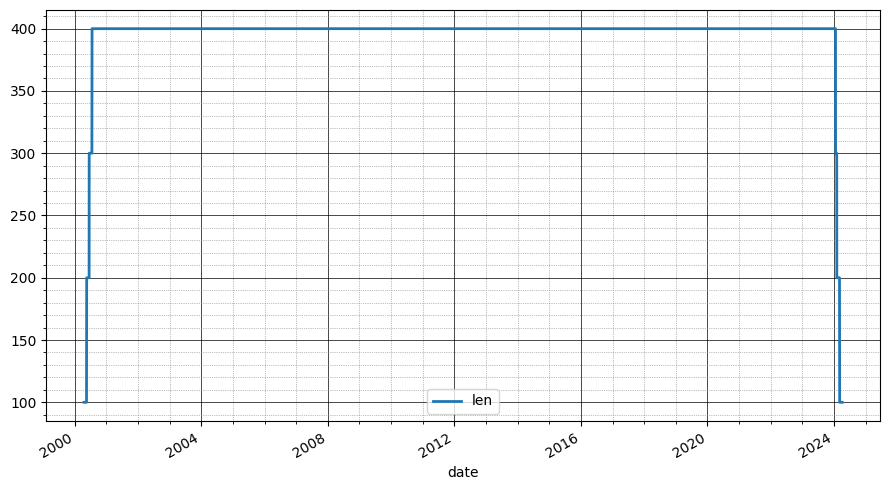

<Figure size 900x500 with 0 Axes>

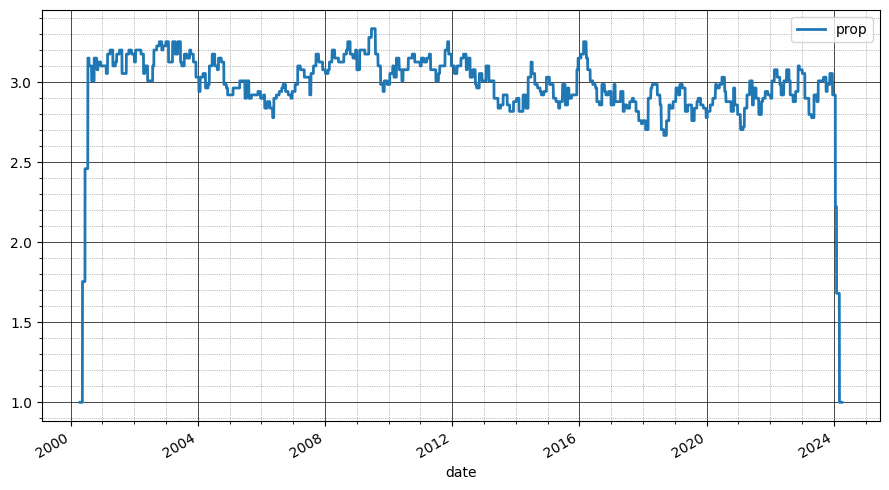

<Figure size 900x500 with 0 Axes>

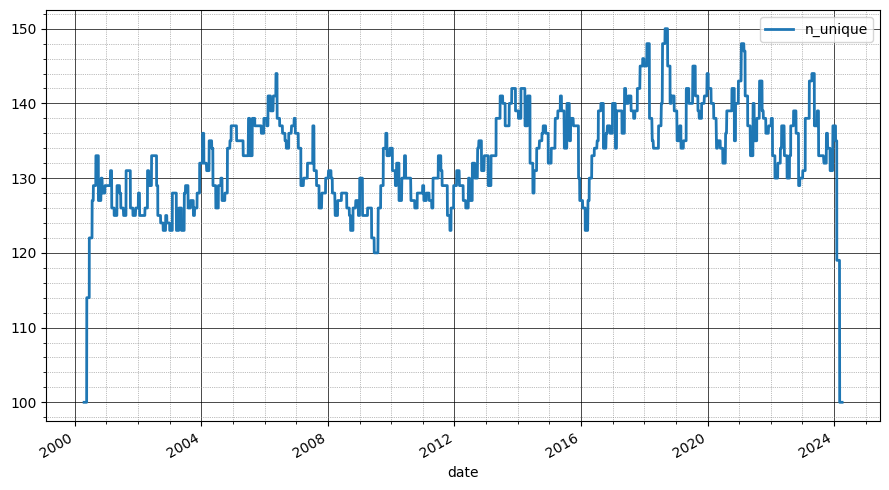

<Figure size 900x500 with 0 Axes>

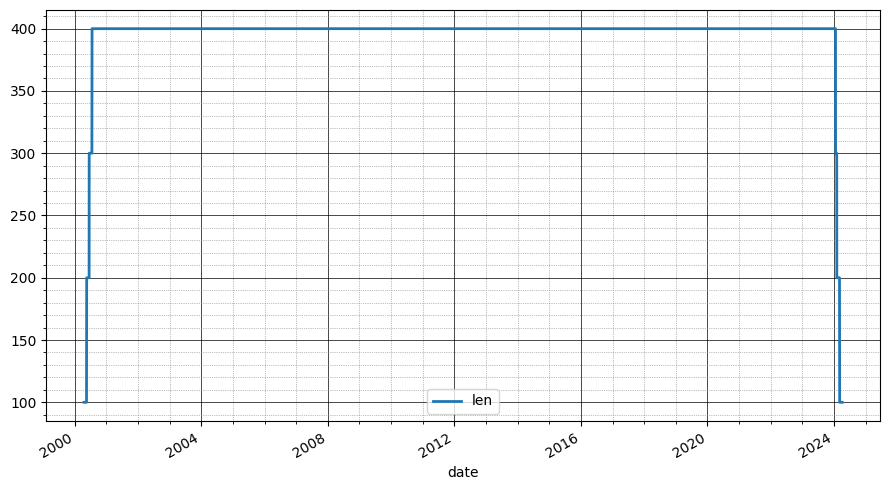

<Figure size 900x500 with 0 Axes>

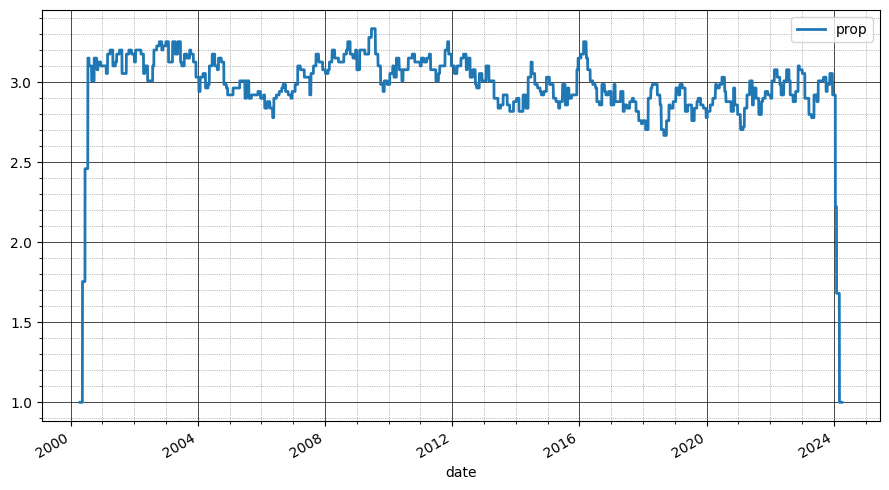

In [51]:
attrs = ['n_unique', 'len']
counts_universes = (
    universes
    .group_by('date')
    .agg([getattr(pl.col(keys[1]), attr)().alias(attr) for attr in attrs])
    .sort('date')
    .with_columns(prop=pl.col('len') / pl.col('n_unique'))
)
for col in attrs + ['prop']:
    plot_ts(counts_universes.select('date', col), 'date')

counts_weights = (
    weights
    .group_by('date')
    .agg([getattr(pl.col(keys[1]), attr)().alias(attr) for attr in attrs])
    .sort('date')
    .with_columns(prop=pl.col('len') / pl.col('n_unique'))
)
for col in attrs + ['prop']:
    plot_ts(counts_universes.select('date', col), 'date')

In [52]:
quantile = 0.01
attrs = ['mean', 'median', ('quantile', quantile), ('quantile', 1 - quantile), 'std']
getattr_cpl = lambda attr: (
    getattr(pl.col('demeaned_weight'), attr[0])(attr[1])
    if isinstance(attr, tuple) else
    getattr(pl.col('demeaned_weight'), attr)()
).over(keys).alias(f'{attr[0]}_{attr[1]}' if isinstance(attr, tuple) else attr)

w_quantiles = (
    weights
    .select([*keys, 'weight', 'weight_normalized'])
    .with_columns(demeaned_weight=pl.col('weight') - pl.col('weight').mean().over(keys))
    .with_columns(demedianed_weight=pl.col('weight') - pl.col('weight').median().over(keys))
    .with_columns(demeaned_weight_normalized=pl.col('weight') - pl.col('weight').mean().over(keys))
    .with_columns(demedianed_weight_normalized=pl.col('weight') - pl.col('weight').median().over(keys))
    .with_columns([getattr_cpl(attr) for attr in attrs])
)

(
    w_quantiles
    .select('demeaned_weight', 'demedianed_weight', 'demeaned_weight_normalized', 'demedianed_weight_normalized')
    .describe(percentiles=percentiles)
)

shape: (13, 5)
┌────────────┬─────────────────┬───────────────────┬───────────────────────┬───────────────────────┐
│ statistic  ┆ demeaned_weight ┆ demedianed_weight ┆ demeaned_weight_norma ┆ demedianed_weight_nor │
│ ---        ┆ ---             ┆ ---               ┆ lized                 ┆ malized               │
│ str        ┆ f64             ┆ f64               ┆ ---                   ┆ ---                   │
│            ┆                 ┆                   ┆ f64                   ┆ f64                   │
╞════════════╪═════════════════╪═══════════════════╪═══════════════════════╪═══════════════════════╡
│ count      ┆ 24124.0         ┆ 24124.0           ┆ 24124.0               ┆ 24124.0               │
│ null_count ┆ 0.0             ┆ 0.0               ┆ 0.0                   ┆ 0.0                   │
│ mean       ┆ 0.0             ┆ -3.0161e-16       ┆ 0.0                   ┆ -3.0161e-16           │
│ std        ┆ 27.643324       ┆ 27.643324         ┆ 27.643324             ┆ 27.643324             │
│ min        ┆ -783.111447     ┆ -783.111447       ┆ -783.111447           ┆ -783.111447           │
│ …          ┆ …               ┆ …                 ┆ …                     ┆ …                     │
│ 50%        ┆ 0.0             ┆ 0.0               ┆ 0.0                   ┆ 0.0                   │
│ 75%        ┆ 0.0             ┆ 0.0               ┆ 0.0                   ┆ 0.0                   │
│ 90%        ┆ 0.0             ┆ 0.0               ┆ 0.0                   ┆ 0.0                   │
│ 99%        ┆ 20.364904       ┆ 20.364904         ┆ 20.364904             ┆ 20.364904             │
│ max        ┆ 783.111447      ┆ 783.111447        ┆ 783.111447            ┆ 783.111447            │
└────────────┴─────────────────┴───────────────────┴───────────────────────┴───────────────────────┘

In [53]:
positions = read_weights_one_hyperparameter(hyper_dict, path_index).collect()
positions.describe()

shape: (9, 4)
┌────────────┬────────────┬────────┬────────────┐
│ statistic  ┆ date       ┆ symbol ┆ weight     │
│ ---        ┆ ---        ┆ ---    ┆ ---        │
│ str        ┆ str        ┆ str    ┆ f64        │
╞════════════╪════════════╪════════╪════════════╡
│ count      ┆ 801121     ┆ 801121 ┆ 22795.0    │
│ null_count ┆ 0          ┆ 0      ┆ 778326.0   │
│ mean       ┆ 2012-06-11 ┆ null   ┆ 0.206424   │
│ std        ┆ null       ┆ null   ┆ 5.727785   │
│ min        ┆ 2000-04-17 ┆ AAL    ┆ -95.26028  │
│ 25%        ┆ 2006-06-13 ┆ null   ┆ -0.287256  │
│ 50%        ┆ 2012-08-08 ┆ null   ┆ -0.000716  │
│ 75%        ┆ 2018-06-11 ┆ null   ┆ 0.286709   │
│ max        ┆ 2024-04-03 ┆ ZS     ┆ 214.289344 │
└────────────┴────────────┴────────┴────────────┘